In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## 1) Data Prep

In [99]:
def process_expense_data(file_path: str):
    """
    Load the CSV, clean columns with NaNs, split Income/Expense into separate columns,
    convert Date to date (no time), drop specified columns, and apply preprocessing pipeline
    that ordinal-encodes categorical features and scales Income/Expense to [0, 1].

    Returns the transformed DataFrame with original category names preserved.
    """
    # Load
    df = pd.read_csv(file_path)
    
    # PRESERVE ORIGINAL CATEGORY NAMES BEFORE ENCODING
    df['CategoryName'] = df['Category'].copy()
    
    # Create Income and Expense columns from 'Income/Expense' and 'Amount'
    if 'Income/Expense' not in df.columns:
        raise ValueError("Column 'Income/Expense' not found in CSV")
    if 'Amount' not in df.columns:
        amount_col = 'INR' if 'INR' in df.columns else None
        if amount_col is None:
            raise ValueError("Amount column not found (expected 'Amount' or 'INR')")
        df['Amount'] = df[amount_col]

    df['Income'] = np.where(df['Income/Expense'].str.strip().str.lower() == 'income', df['Amount'], 0.0)
    df['Expense'] = np.where(df['Income/Expense'].str.strip().str.lower() == 'expense', df['Amount'], 0.0)

    # Convert Date to datetime and drop time component
    if 'Date' not in df.columns:
        raise ValueError("Column 'Date' not found in CSV")
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.date

    # Drop specified columns
    drop_cols = ['Account', 'Note', 'INR', 'Currency', 'Account.1']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])

    # Drop columns that have any NaN values
    df = df.dropna(axis=1, how='any')

    # Identify categorical features for encoding (exclude CategoryName from encoding)
    categorical_cols = [c for c in df.columns if df[c].dtype == 'object' and c not in ['Date', 'CategoryName']]
    
    # Numeric columns to scale
    numeric_cols = [c for c in ['Income'] if c in df.columns]

    # Build preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
            ('num', MinMaxScaler(feature_range=(0, 1)), numeric_cols),
        ],
        remainder='passthrough'  # This will preserve CategoryName and Date
    )

    pipeline = Pipeline(steps=[('preprocess', preprocessor)])
    
    # Fit and transform
    transformed = pipeline.fit_transform(df)

    # Build column names for transformed DataFrame
    new_columns = []
    if categorical_cols:
        new_columns.extend(categorical_cols)
    if numeric_cols:
        new_columns.extend(numeric_cols)
    # Append remainder columns (CategoryName, Date)
    remainder_cols = [c for c in df.columns if c not in set(categorical_cols + numeric_cols)]
    new_columns.extend(remainder_cols)
    
    df_transformed = pd.DataFrame(transformed, columns=new_columns)
    df_transformed['frequency'] = df_transformed['Category'].value_counts().sort_values(ascending=False)
    return df_transformed

In [100]:
# Demo usage: process the provided CSV and preview
processed_df = process_expense_data('expense_data_1.csv')
processed_df.head(10)

,Category,Income/Expense,Income,Date,Amount,CategoryName,Expense,frequency
0,4.0,0.0,0.0,2022-03-02,50.0,Food,50.0,6.0
1,7.0,0.0,0.0,2022-03-02,300.0,Other,300.0,7.0
2,4.0,0.0,0.0,2022-03-01,78.0,Food,78.0,1.0
3,12.0,0.0,0.0,2022-03-01,30.0,Transportation,30.0,1.0
4,4.0,0.0,0.0,2022-03-01,67.0,Food,67.0,156.0
5,7.0,1.0,0.01,2022-03-01,100.0,Other,0.0,1.0
6,7.0,1.0,0.05,2022-03-01,500.0,Other,0.0,6.0
7,4.0,0.0,0.0,2022-02-28,339.15,Food,339.15,60.0
8,7.0,1.0,0.02,2022-02-28,200.0,Other,0.0,1.0
9,4.0,0.0,0.0,2022-02-27,243.0,Food,243.0,1.0


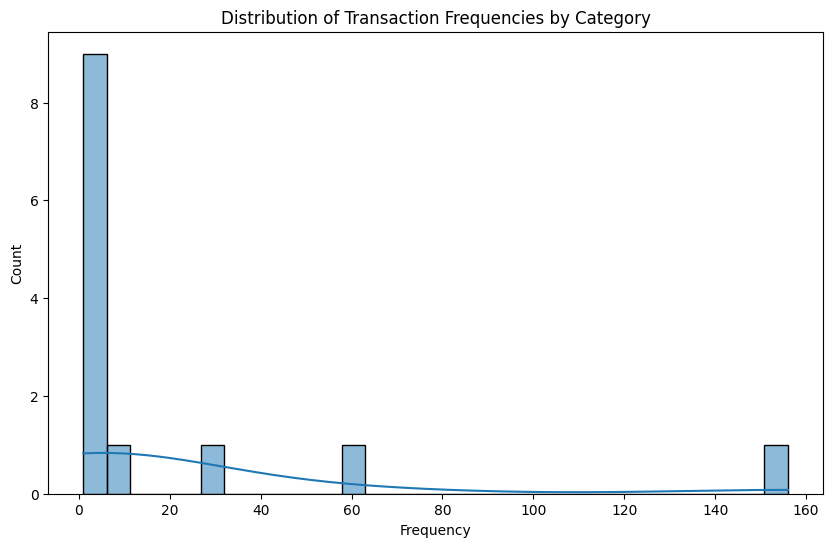

In [101]:
plt.figure(figsize=(10, 6))
seaborn.histplot(processed_df['frequency'], bins=30, kde=True)
plt.title('Distribution of Transaction Frequencies by Category')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.show()  

## Clustering Algos

<Figure size 1000x600 with 0 Axes>

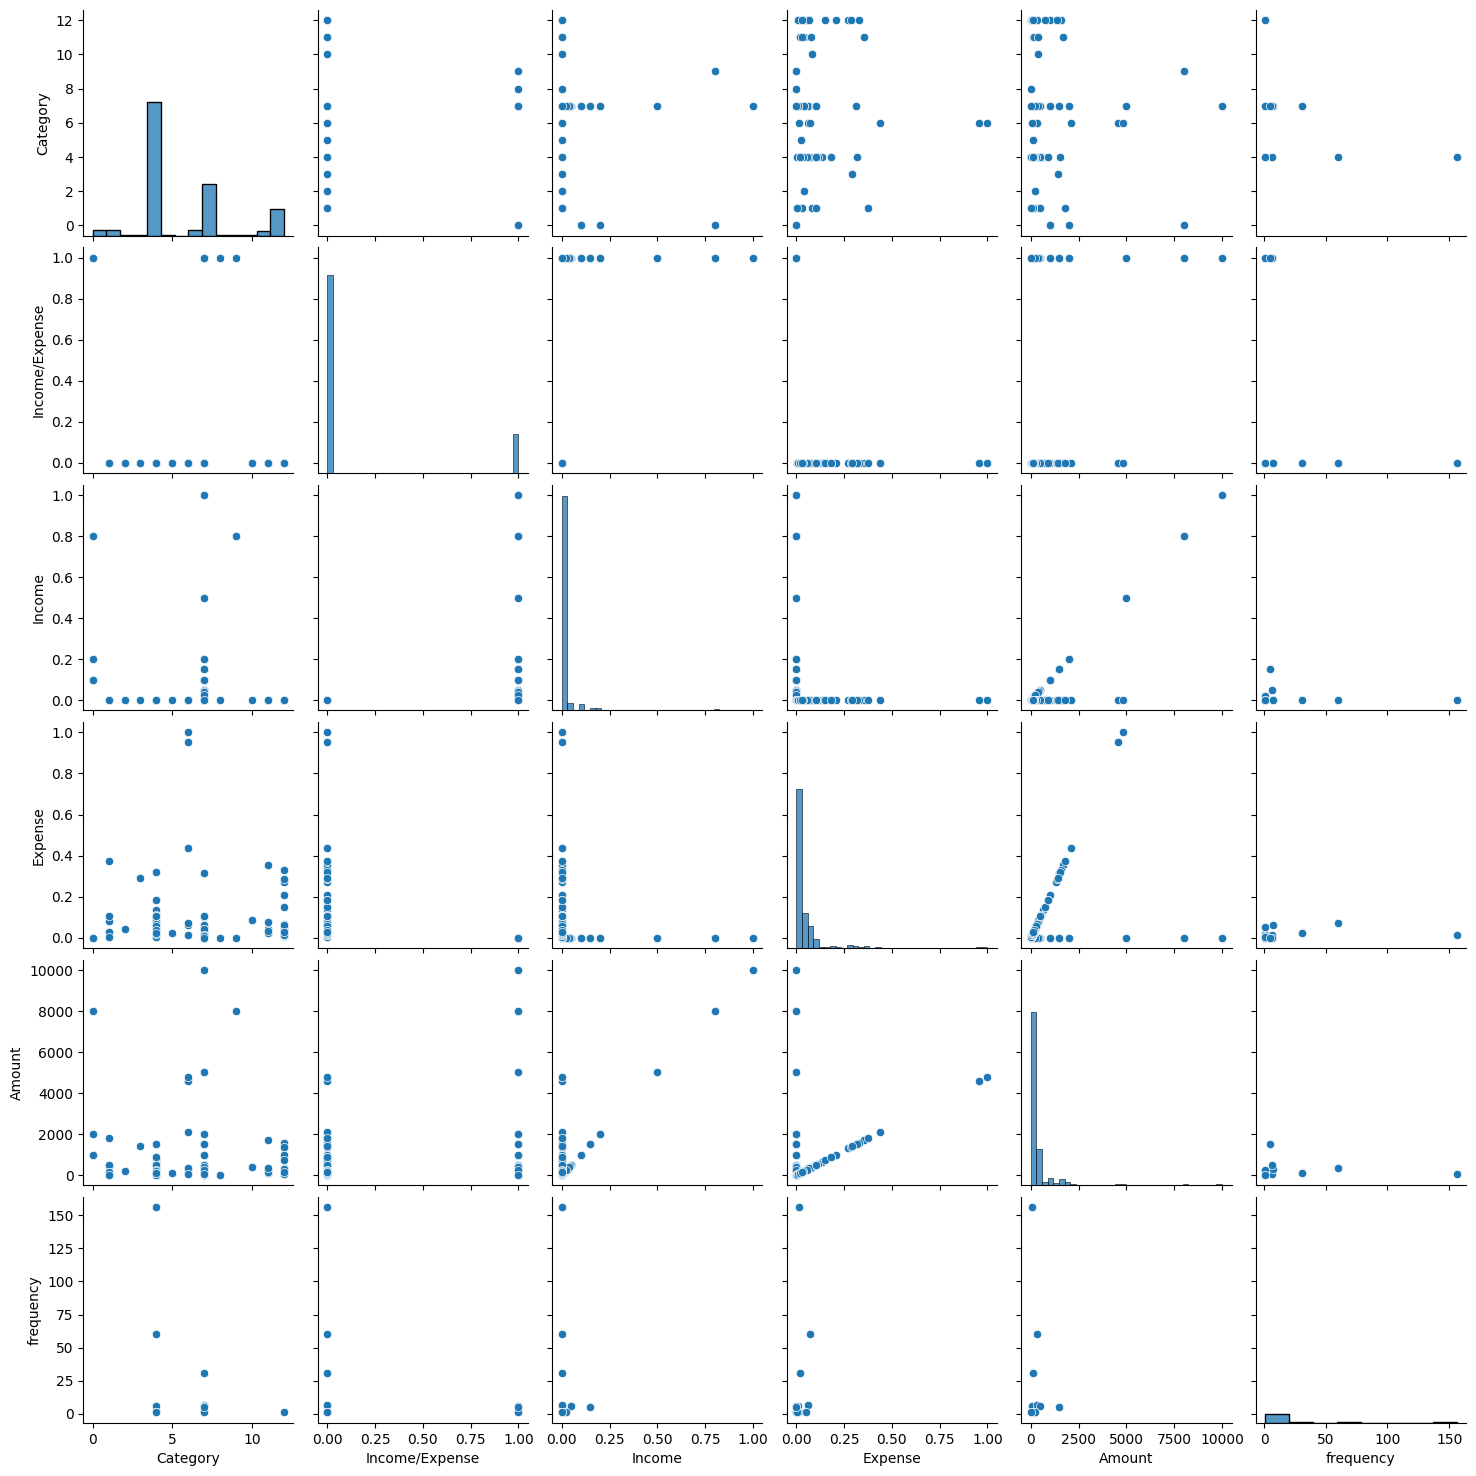

In [71]:
plt.figure(figsize=(10, 6))
sns.pairplot(processed_df)
plt.show()

### Clustering

In [80]:
# 1) Feature preparation for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Ensure processed_df exists
if 'processed_df' not in globals():
    processed_df = process_expense_data('expense_data_1.csv')

# Select numeric features (exclude frequency for separate analysis if desired)
numeric_df = processed_df[['Category', 'Expense']].copy()

# Optionally drop very low-variance columns (all zeros) if any
low_var_cols = [c for c in numeric_df.columns if numeric_df[c].nunique() <= 1]
if low_var_cols:
    numeric_df = numeric_df.drop(columns=low_var_cols)

# PCA to 2 components for visualization space
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(numeric_df)

pca_df = pd.DataFrame(X_pca, columns=['PC1','PC2'])
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")


PCA explained variance ratio: [0.99877336 0.00122664]


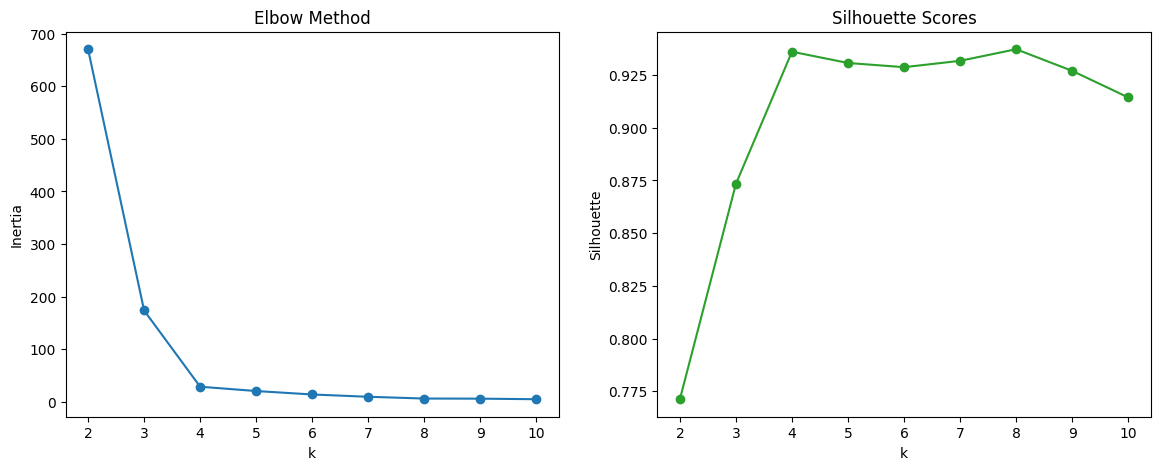

Chosen k (max silhouette): 8


C:\Users\Arnav Waghdhare\AppData\Local\Temp\ipykernel_32456\3461753093.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', best_k)


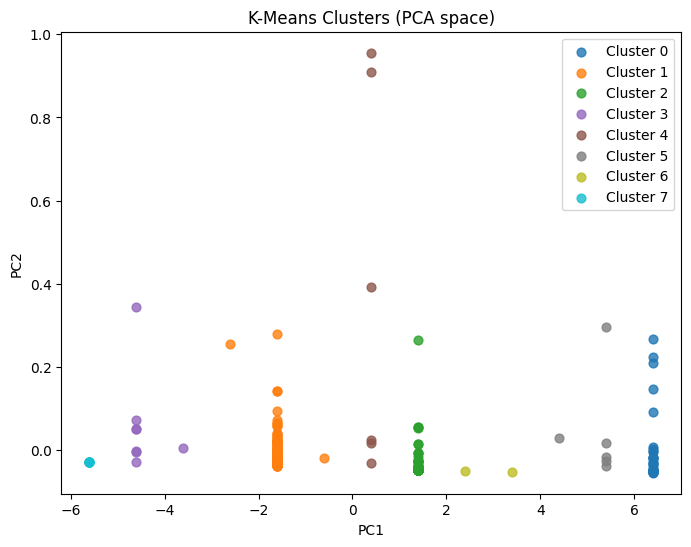

In [81]:
# 2) K-Means: Elbow & Silhouette to choose k
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
sil_scores = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(numeric_df)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(numeric_df, labels))

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(list(K_range), inertias, marker='o', color='tab:blue')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia')
ax[1].plot(list(K_range), sil_scores, marker='o', color='tab:green')
ax[1].set_title('Silhouette Scores')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette')
plt.show()

best_k = K_range[sil_scores.index(max(sil_scores))]
print(f"Chosen k (max silhouette): {best_k}")

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(numeric_df)

pca_df['KMeansCluster'] = kmeans_labels

plt.figure(figsize=(8,6))
palette = plt.cm.get_cmap('tab10', best_k)
for cluster in range(best_k):
    subset = pca_df[pca_df['KMeansCluster']==cluster]
    plt.scatter(subset['PC1'], subset['PC2'], s=40, alpha=0.8, color=palette(cluster), label=f'Cluster {cluster}')
plt.title('K-Means Clusters (PCA space)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


In [86]:
processed_df['KMeansCluster'] = kmeans_labels

cluster_profiles = processed_df.groupby('KMeansCluster').agg({
    'CategoryName': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],  # Most common category
    'Income': 'mean',
    'Expense': 'mean',
    'Amount': 'mean',
    'CategoryName': ['count', lambda x: x.nunique()]  # Transaction count & category diversity
}).round(2)

# Flatten column names
cluster_profiles.columns = ['TopCategory', 'AvgIncome', 'AvgExpense', 'AvgAmount', 'TxnCount']

print("=== K-Means Cluster Profiles ===")
print(cluster_profiles.sort_values('TxnCount', ascending=False))

# Show category distribution per cluster
print("\n=== Category Distribution by Cluster ===")
category_dist = pd.crosstab(processed_df['KMeansCluster'], processed_df['CategoryName'], margins=True)
print(category_dist)

=== K-Means Cluster Profiles ===
               TopCategory  AvgIncome AvgExpense AvgAmount     TxnCount
KMeansCluster                                                          
6                        2          2    0.40015       0.0       4001.5
7                        6          1   0.233333       0.0  2333.333333
4                        6          1        0.0  0.423194  2031.333333
2                       60          1   0.054585  0.017767   631.133333
5                        6          2        0.0  0.101171       485.62
3                        8          2        0.0  0.093333        448.0
0                       31          1        0.0  0.061853   296.896774
1                      158          3        0.0  0.032848   157.669367

=== Category Distribution by Cluster ===
CategoryName   Allowance  Apparel  Beauty  Education  Food  Gift  Household  \
KMeansCluster                                                                 
0                      0        0       0      

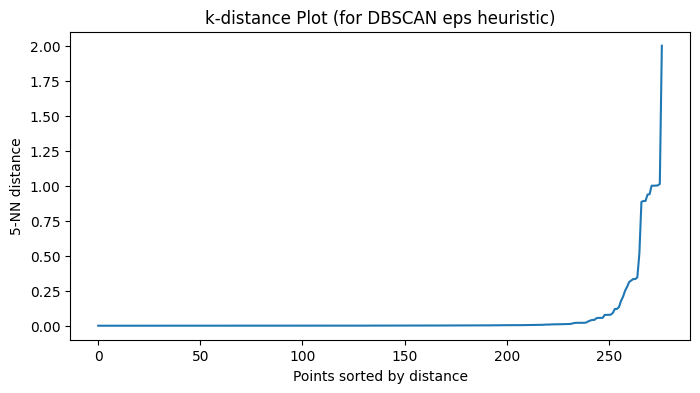

Candidate eps (90th percentile): 0.077
DBSCAN labels: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)] ( -1 denotes noise )


C:\Users\Arnav Waghdhare\AppData\Local\Temp\ipykernel_32456\2567101644.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


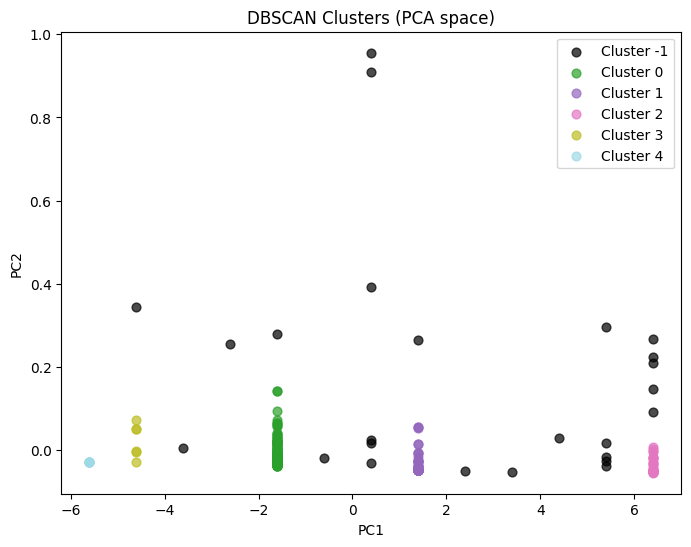

In [87]:
# 3) DBSCAN clustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Heuristic choice of eps using k-distance plot (k = min_samples)
min_samples = 5
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(numeric_df)
knn_distances, _ = nbrs.kneighbors(numeric_df)
# Take the distances to the k-th neighbor
k_dist = np.sort(knn_distances[:, -1])

plt.figure(figsize=(8,4))
plt.plot(k_dist)
plt.title('k-distance Plot (for DBSCAN eps heuristic)')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{min_samples}-NN distance')
plt.show()

# Simple heuristic: choose an elbow near 90th percentile
candidate_eps = float(np.percentile(k_dist, 90))
print(f"Candidate eps (90th percentile): {candidate_eps:.3f}")

dbscan = DBSCAN(eps=candidate_eps, min_samples=min_samples)
db_labels = dbscan.fit_predict(numeric_df)

pca_df['DBSCANCluster'] = db_labels

unique_labels = sorted(set(db_labels))
print(f"DBSCAN labels: {unique_labels} ( -1 denotes noise )")

plt.figure(figsize=(8,6))
colors = plt.cm.get_cmap('tab20', len(unique_labels))
for idx, label in enumerate(unique_labels):
    subset = pca_df[pca_df['DBSCANCluster']==label]
    color = 'k' if label == -1 else colors(idx)
    plt.scatter(subset['PC1'], subset['PC2'], s=40, alpha=0.7, color=color, label=f'Cluster {label}')
plt.title('DBSCAN Clusters (PCA space)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


In [88]:
processed_df['DBSCANCluster'] = db_labels

# Profile DBSCAN clusters (including noise points)
print("=== DBSCAN Cluster Profiles ===")
dbscan_profiles = processed_df.groupby('DBSCANCluster').agg({
    'CategoryName': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],  # Most common category
    'Income': 'mean',
    'Expense': 'mean', 
    'Amount': 'mean',
    'CategoryName': 'count'  # Transaction count
}).round(2)

dbscan_profiles.columns = ['TopCategory', 'AvgIncome', 'AvgAmount', 'TxnCount']
print(dbscan_profiles.sort_values('TxnCount', ascending=False))

# Analyze noise points (cluster -1)
if -1 in db_labels:
    noise_points = processed_df[processed_df['DBSCANCluster'] == -1]
    print(f"\n=== NOISE ANALYSIS (Cluster -1) ===")
    print(f"Noise points: {len(noise_points)} ({len(noise_points)/len(processed_df)*100:.1f}% of data)")
    print(f"Noise categories: {noise_points['CategoryName'].value_counts().to_dict()}")
    print(f"Noise amount range: ₹{noise_points['Amount'].min():.2f} - ₹{noise_points['Amount'].max():.2f}")
    print(f"Noise avg amount: ₹{noise_points['Amount'].mean():.2f}")

# Category distribution across DBSCAN clusters
print("\n=== DBSCAN Category Distribution ===")
dbscan_crosstab = pd.crosstab(processed_df['DBSCANCluster'], processed_df['CategoryName'], margins=True)
print(dbscan_crosstab)

# Compare with K-Means: find overlapping behavior patterns
if 'KMeansCluster' in processed_df.columns:
    print("\n=== DBSCAN vs K-Means Overlap ===")
    overlap = pd.crosstab(processed_df['DBSCANCluster'], processed_df['KMeansCluster'], margins=True)
    print(overlap)

=== DBSCAN Cluster Profiles ===
               TopCategory AvgIncome AvgAmount     TxnCount
DBSCANCluster                                              
 4                       6  0.233333       0.0  2333.333333
-1                      25  0.032012  0.230064    1424.4288
 1                      59   0.05551  0.012772    616.40678
 3                       6       0.0  0.055139   264.666667
 0                     155       0.0  0.029391   141.075871
 2                      26       0.0  0.025952   124.569231

=== NOISE ANALYSIS (Cluster -1) ===
Noise points: 25 (9.0% of data)
Noise categories: {'Household': 6, 'Social Life': 5, 'Transportation': 5, 'Other': 1, 'Food': 1, 'Education': 1, 'Salary': 1, 'Self-development': 1, 'Apparel': 1, 'Beauty': 1, 'Gift': 1, 'Petty cash': 1}
Noise amount range: ₹3.00 - ₹8000.00
Noise avg amount: ₹1424.43

=== DBSCAN Category Distribution ===
CategoryName   Allowance  Apparel  Beauty  Education  Food  Gift  Household  \
DBSCANCluster                     

BIRCH produced 7 clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]


C:\Users\Arnav Waghdhare\AppData\Local\Temp\ipykernel_32456\2631965451.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set3', len(unique_birch))


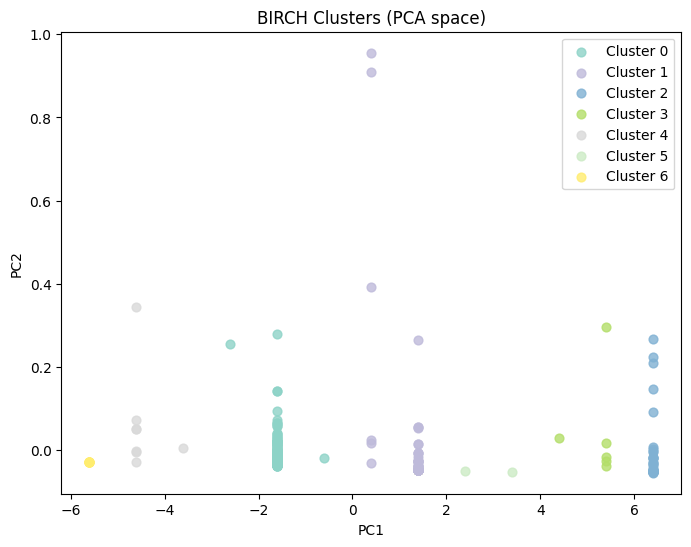

In [89]:
# 4) BIRCH clustering
from sklearn.cluster import Birch

birch = Birch(n_clusters=None, threshold=0.5)
birch_labels = birch.fit_predict(numeric_df)

pca_df['BIRCHCluster'] = birch_labels
unique_birch = sorted(set(birch_labels))
print(f"BIRCH produced {len(unique_birch)} clusters: {unique_birch}")

plt.figure(figsize=(8,6))
colors = plt.cm.get_cmap('Set3', len(unique_birch))
for idx, label in enumerate(unique_birch):
    subset = pca_df[pca_df['BIRCHCluster']==label]
    plt.scatter(subset['PC1'], subset['PC2'], s=40, alpha=0.8, color=colors(idx), label=f'Cluster {label}')
plt.title('BIRCH Clusters (PCA space)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


### Cluster Interpretation
- K-Means partitions points into `best_k` compact, spherical clusters maximizing silhouette; useful for groups differentiated by spending intensity or category mix.
- DBSCAN identifies dense regions and labels sparse points/noise (`-1`), revealing outlier transaction behavior patterns that do not fit recurring spending profiles.
- BIRCH incrementally builds a clustering feature tree; adaptive number of clusters can expose hierarchical or granular spending sub-patterns.
- Compare overlap: Points stable across algorithms (same relative region) indicate robust behavioral segments; DBSCAN noise points may be anomalous one-off high or low spends.
- Next steps: Profile clusters by mean Income, Expense, top Category frequency to label segments (e.g., High-Food-Low-Transport vs Mixed-Moderate).

## Category-wise Spending Trend Analysis

In [90]:
from prophet import Prophet

In [102]:
processed_df.drop(columns=['KMeansCluster', 'DBSCANCluster'], inplace=True, errors='ignore')
processed_df.columns

Index(['Category', 'Income/Expense', 'Income', 'Date', 'Amount',
       'CategoryName', 'Expense', 'frequency'],
      dtype='object')

In [110]:
df_prophet = processed_df[['Date', 'Expense']].rename(columns={'Date': 'ds', 'Expense': 'y'})

model = Prophet()
model.fit(df_prophet)

forecast = model.predict(df_prophet[['ds']])

trend = forecast['trend'].values
seasonal = forecast['weekly'].values

result = np.array([trend, seasonal])

10:16:32 - cmdstanpy - INFO - Chain [1] start processing
10:16:32 - cmdstanpy - INFO - Chain [1] done processing


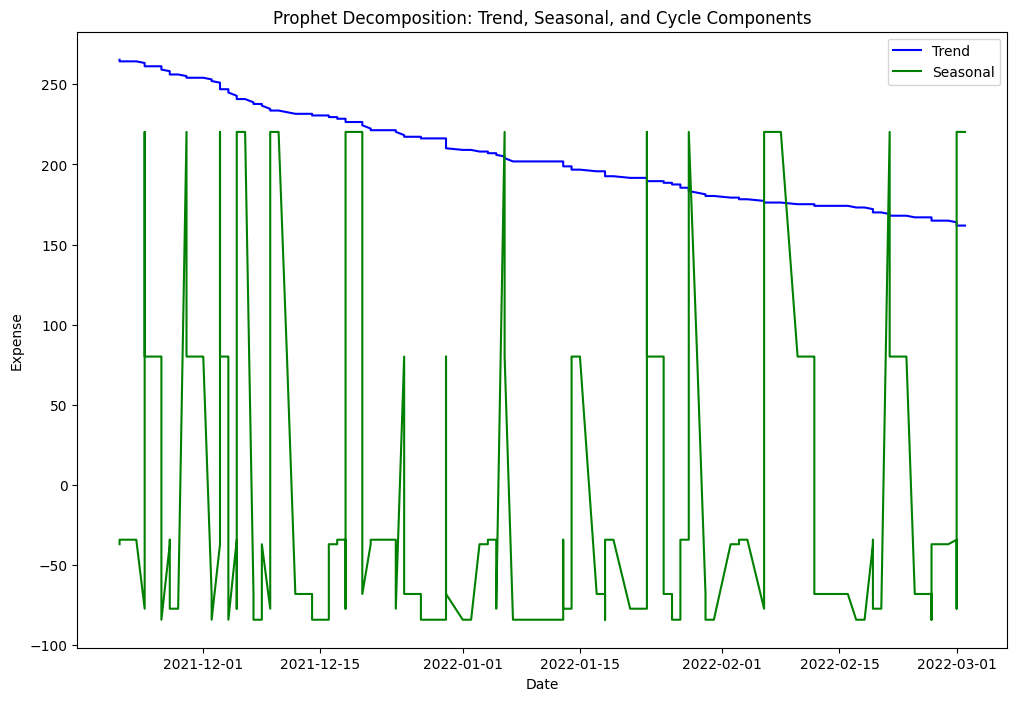

In [111]:
plt.figure(figsize=(12, 8))
plt.plot(df_prophet['ds'], result[0], label='Trend', color='blue')
plt.plot(df_prophet['ds'], result[1], label='Seasonal', color='green')
plt.xlabel('Date')
plt.ylabel('Expense')
plt.title('Prophet Decomposition: Trend, Seasonal, and Cycle Components')
plt.legend()
plt.show()